# Терешенков БВТ2203. Лаб. работа №5. Авторегрессионная модель PixelCNN для датасета Fashion MNIST

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x * 255).long()
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mask_type = mask_type
        self.register_buffer('mask', self.weight.data.clone())

        _, _, kH, kW = self.weight.size()
        centerH, centerW = kH // 2, kW // 2

        self.mask.fill_(0)

        self.mask[:, :, :centerH, :] = 1

        self.mask[:, :, centerH, :centerW] = 1

        if self.mask_type == 'B':
            self.mask[:, :, centerH, centerW] = 1


    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)


class PixelCNN(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=64, num_colors=256):
        super().__init__()

        self.num_colors = num_colors

        self.mask_a = nn.Sequential(
            MaskedConv2d('A', input_channels, hidden_channels, kernel_size=7, padding=3, bias=False),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True)
        )

        self.mask_b1 = nn.Sequential(
            MaskedConv2d('B', hidden_channels, hidden_channels, kernel_size=7, padding=3, bias=False),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True)
        )

        self.mask_b2 = nn.Sequential(
            MaskedConv2d('B', hidden_channels, hidden_channels, kernel_size=7, padding=3, bias=False),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True)
        )

        self.output = nn.Conv2d(hidden_channels, num_colors * input_channels, kernel_size=1)

    def forward(self, x):
        x = self.mask_a(x)
        x = self.mask_b1(x)
        x = self.mask_b2(x)
        x = self.output(x)
        return x

In [11]:
model = PixelCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)

        optimizer.zero_grad()

        output = model(images.float() / 255.0)

        target = images.squeeze(1)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 2.6180
Epoch [2/10], Loss: 2.2558
Epoch [3/10], Loss: 2.2119
Epoch [4/10], Loss: 2.1897
Epoch [5/10], Loss: 2.1689
Epoch [6/10], Loss: 2.1559
Epoch [7/10], Loss: 2.1469
Epoch [8/10], Loss: 2.1334
Epoch [9/10], Loss: 2.1253
Epoch [10/10], Loss: 2.1210


...........

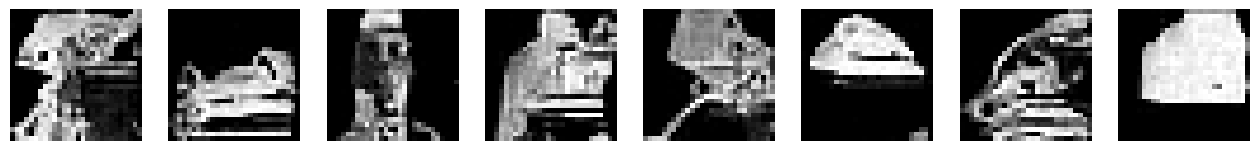

In [ ]:
@torch.no_grad()
def generate_images(model, img_size=(1, 28, 28), num_samples=10):
    model.eval()
    samples = torch.zeros(num_samples, *img_size).to(device)
    for i in range(img_size[1]):
        for j in range(img_size[2]):

            output = model(samples.float() / 255.0)

            logits = output[:, :, i, j]

            probs = torch.softmax(logits, dim=1)

            pixel_value = torch.multinomial(probs, 1).squeeze(-1)

            samples[:, :, i, j] = pixel_value.long().unsqueeze(1)

            if (i * img_size[2] + j) % (img_size[1] * img_size[2] // 10) == 0:
                 print(".", end="", flush=True)

    return samples.cpu().numpy().astype(np.uint8)

generated_samples = generate_images(model, num_samples=8)

fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i in range(8):
    axes[i].imshow(generated_samples[i, 0], cmap='gray')
    axes[i].axis('off')
plt.show()